In [1]:
import pandas as pd
import numpy as np

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC

from niapy.problems import Problem
from niapy.task import Task
from niapy.algorithms.basic import ParticleSwarmOptimization

In [5]:
# pip install niapy

In [7]:
dataset = pd.read_csv("Chinese_data_Water.csv")
dataset

,pH,DO(mg/l),CODMn(mg/l),NH3-N(mg/l),potability
0,7.09,10.00,5.7,0.33,3
1,6.94,12.00,5.4,0.40,3
2,7.20,9.60,4.9,0.34,3
3,6.80,11.60,6.3,0.59,4
4,6.75,11.00,6.2,0.64,4
...,...,...,...,...,...
33822,7.50,6.14,1.5,0.15,2
33823,7.92,9.56,1.5,0.20,2
33824,7.65,10.50,2.1,0.35,2
33825,7.44,9.87,2.0,0.11,1


In [9]:
X=dataset.drop("potability", axis="columns")

In [11]:
y=dataset.potability

In [13]:
feature_names = X.columns

In [14]:
feature_names

Index(['pH', 'DO(mg/l)', 'CODMn(mg/l)', 'NH3-N(mg/l)'], dtype='object')

In [15]:
class SVMFeatureSelection(Problem):
    def __init__(self, X_train, y_train, alpha=0.99):
        super().__init__(dimension=X_train.shape[1], lower=0, upper=1)
        self.X_train = X_train
        self.y_train = y_train
        self.alpha = alpha

    def _evaluate(self, x):
        selected = x > 0.5
        num_selected = selected.sum()
        if num_selected == 0:
            return 1.0
        accuracy = cross_val_score(SVC(), self.X_train[:, selected], self.y_train, cv=2, n_jobs=-1).mean()
        score = 1 - accuracy
        num_features = self.X_train.shape[1]
        return self.alpha * score + (1 - self.alpha) * (num_selected / num_features)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1234)

problem = SVMFeatureSelection(X_train, y_train)
task = Task(problem, max_iters=10)
algorithm = ParticleSwarmOptimization(population_size=10, seed=1234)
best_features, best_fitness = algorithm.run(task)

selected_features = best_features > 0.5
print('Number of selected features:', selected_features.sum())
print('Selected features:', ', '.join(feature_names[selected_features].tolist()))

model_selected = SVC()
model_all = SVC()

model_selected.fit(X_train[:, selected_features], y_train)
print('Subset accuracy:', model_selected.score(X_test[:, selected_features], y_test))

model_all.fit(X_train, y_train)
print('All Features Accuracy:', model_all.score(X_test, y_test))

InvalidIndexError: ignored

In [17]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier


# error rate
def error_rate(xtrain, ytrain, x, opts):
    # parameters
    k     = opts['k']
    fold  = opts['fold']
    xt    = fold['xt']
    yt    = fold['yt']
    xv    = fold['xv']
    yv    = fold['yv']

    # Number of instances
    num_train = np.size(xt, 0)
    num_valid = np.size(xv, 0)
    # Define selected features
    xtrain  = xt[:, x == 1]
    ytrain  = yt.reshape(num_train)  # Solve bug
    xvalid  = xv[:, x == 1]
    yvalid  = yv.reshape(num_valid)  # Solve bug
    # Training
    mdl     = KNeighborsClassifier(n_neighbors = k)
    mdl.fit(xtrain, ytrain)
    # Prediction
    ypred   = mdl.predict(xvalid)
    acc     = np.sum(yvalid == ypred) / num_valid
    error   = 1 - acc

    return error


# Error rate & Feature size
def Fun(xtrain, ytrain, x, opts):
    # Parameters
    alpha    = 0.99
    beta     = 1 - alpha
    # Original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if num_feat == 0:
        cost  = 1
    else:
        # Get error rate
        error = error_rate(xtrain, ytrain, x, opts)
        # Objective function
        cost  = alpha * error + beta * (num_feat / max_feat)

    return cost

In [18]:
import numpy as np
from numpy.random import rand
# from FS.functionHO import Fun


def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()

    return X


def init_velocity(lb, ub, N, dim):
    V    = np.zeros([N, dim], dtype='float')
    Vmax = np.zeros([1, dim], dtype='float')
    Vmin = np.zeros([1, dim], dtype='float')
    # Maximum & minimum velocity
    for d in range(dim):
        Vmax[0,d] = (ub[0,d] - lb[0,d]) / 2
        Vmin[0,d] = -Vmax[0,d]

    for i in range(N):
        for d in range(dim):
            V[i,d] = Vmin[0,d] + (Vmax[0,d] - Vmin[0,d]) * rand()

    return V, Vmax, Vmin


def binary_conversion(X, thres, N, dim):
    Xbin = np.zeros([N, dim], dtype='int')
    for i in range(N):
        for d in range(dim):
            if X[i,d] > thres:
                Xbin[i,d] = 1
            else:
                Xbin[i,d] = 0

    return Xbin


def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub

    return x


def jfs(xtrain, ytrain, opts):
    # Parameters
    ub    = 1
    lb    = 0
    thres = 0.5
    w     = 0.9    # inertia weight
    c1    = 2      # acceleration factor
    c2    = 2      # acceleration factor

    N        = opts['N']
    max_iter = opts['T']
    if 'w' in opts:
        w    = opts['w']
    if 'c1' in opts:
        c1   = opts['c1']
    if 'c2' in opts:
        c2   = opts['c2']

    # Dimension
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')

    # Initialize position & velocity
    X             = init_position(lb, ub, N, dim)
    V, Vmax, Vmin = init_velocity(lb, ub, N, dim)

    # Pre
    fit   = np.zeros([N, 1], dtype='float')
    Xgb   = np.zeros([1, dim], dtype='float')
    fitG  = float('inf')
    Xpb   = np.zeros([N, dim], dtype='float')
    fitP  = float('inf') * np.ones([N, 1], dtype='float')
    curve = np.zeros([1, max_iter], dtype='float')
    t     = 0

    while t < max_iter:
        # Binary conversion
        Xbin = binary_conversion(X, thres, N, dim)

        # Fitness
        for i in range(N):
            fit[i,0] = Fun(xtrain, ytrain, Xbin[i,:], opts)
            if fit[i,0] < fitP[i,0]:
                Xpb[i,:]  = X[i,:]
                fitP[i,0] = fit[i,0]
            if fitP[i,0] < fitG:
                Xgb[0,:]  = Xpb[i,:]
                fitG      = fitP[i,0]

        # Store result
        curve[0,t] = fitG.copy()
        print("Iteration:", t + 1)
        print("Best (PSO):", curve[0,t])
        t += 1

        for i in range(N):
            for d in range(dim):
                # Update velocity
                r1     = rand()
                r2     = rand()
                V[i,d] = w * V[i,d] + c1 * r1 * (Xpb[i,d] - X[i,d]) + c2 * r2 * (Xgb[0,d] - X[i,d])
                # Boundary
                V[i,d] = boundary(V[i,d], Vmin[0,d], Vmax[0,d])
                # Update position
                X[i,d] = X[i,d] + V[i,d]
                # Boundary
                X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])


    # Best feature subset
    Gbin       = binary_conversion(Xgb, thres, 1, dim)
    Gbin       = Gbin.reshape(dim)
    pos        = np.asarray(range(0, dim))
    sel_index  = pos[Gbin == 1]
    num_feat   = len(sel_index)
    # Create dictionary
    pso_data = {'sf': sel_index, 'c': curve, 'nf': num_feat}

    return pso_data

<ipython-input-28-825d7731773b>:13: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(),inplace=True)


Iteration: 1
Best (PSO): 0.09407819466945762
Iteration: 2
Best (PSO): 0.09304767810291192
Iteration: 3
Best (PSO): 0.09304767810291192
Iteration: 4
Best (PSO): 0.09044075900729757
Iteration: 5
Best (PSO): 0.08837320248318971
Iteration: 6
Best (PSO): 0.08541975512193722
Iteration: 7
Best (PSO): 0.08541975512193722
Iteration: 8
Best (PSO): 0.08423156604395762
Iteration: 9
Best (PSO): 0.08423156604395762
Iteration: 10
Best (PSO): 0.08423156604395762
Accuracy: 92.03668391900482
Feature Size: 41


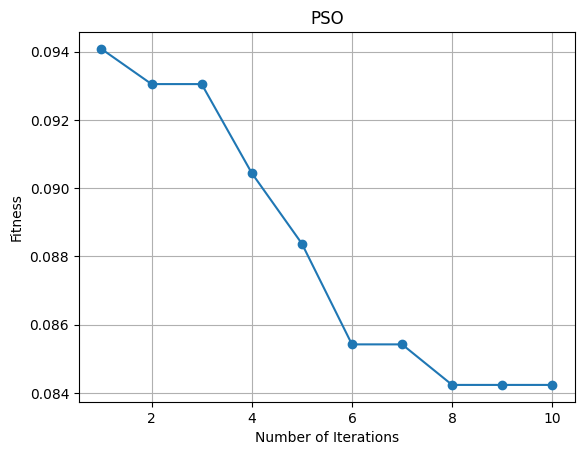

In [28]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
# from FS.pso import jfs   # change this to switch algorithm
import matplotlib.pyplot as plt



data=pd.read_csv("All.csv")
data.drop(columns=['Entropy_DirectoryName', 'NumberRate_Extension', 'argPathRatio'],inplace=True)
data.fillna(data.Entropy_Extension.mean(),inplace=True)
data.fillna(data.mean(),inplace=True)

data["URL_Type_obf_Type"].replace({'Defacement': 0,'benign': 1,'malware':2,'phishing':3,'spam':4},inplace=True)


# data.dropna( subset=['ammonia', 'is_safe'], axis=0, inplace=True)
# data  = pd.read_csv('I:/Wrapper Function_(ashraf_sir)/Wrapper-Feature-Selection-Toolbox-Python/ionosphere.csv')
data  = data.values
feat  = np.asarray(data[:, 0:-1])
label = np.asarray(data[:, -1])

# split data into train & validation (70 -- 30)
xtrain, xtest, ytrain, ytest = train_test_split(feat, label, test_size=0.3, stratify=label)
fold = {'xt':xtrain, 'yt':ytrain, 'xv':xtest, 'yv':ytest}

# parameter
k    = 5     # k-value in KNN
N    = 2   # number of particles
T    = 10  # maximum number of iterations
opts = {'k':k, 'fold':fold, 'N':N, 'T':T}

# perform feature selection
fmdl = jfs(feat, label, opts)
sf   = fmdl['sf']

# model with selected features
num_train = np.size(xtrain, 0)
num_valid = np.size(xtest, 0)
x_train   = xtrain[:, sf]
y_train   = ytrain.reshape(num_train)  # Solve bug
x_valid   = xtest[:, sf]
y_valid   = ytest.reshape(num_valid)  # Solve bug

mdl       = KNeighborsClassifier(n_neighbors = k)
mdl.fit(x_train, y_train)

# accuracy
y_pred    = mdl.predict(x_valid)
Acc       = np.sum(y_valid == y_pred)  / num_valid
print("Accuracy:", 100 * Acc)

# number of selected features
num_feat = fmdl['nf']
print("Feature Size:", num_feat)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [29]:
fmdl

{'sf': array([ 1,  2,  3,  4,  5,  6, 10, 11, 12, 14, 17, 18, 19, 20, 24, 28, 29,
        31, 33, 35, 36, 42, 43, 44, 45, 47, 49, 51, 53, 55, 56, 57, 58, 59,
        60, 62, 66, 68, 69, 70, 74]),
 'c': array([[0.09407819, 0.09304768, 0.09304768, 0.09044076, 0.0883732 ,
         0.08541976, 0.08541976, 0.08423157, 0.08423157, 0.08423157]]),
 'nf': 41}

In [30]:
sf

array([ 1,  2,  3,  4,  5,  6, 10, 11, 12, 14, 17, 18, 19, 20, 24, 28, 29,
       31, 33, 35, 36, 42, 43, 44, 45, 47, 49, 51, 53, 55, 56, 57, 58, 59,
       60, 62, 66, 68, 69, 70, 74])

In [21]:
dataset=dataset.fillna(dataset.mean())